In [98]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import simpy
from random import sample 

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import q_network
from tf_agents.networks import categorical_q_network

from tf_agents.policies import policy_saver
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.trajectories import time_step as ts
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import policy_step

#from env.RideSimulator.Grid import Grid
import tf_agents


import os,sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from RideSimulator.taxi_sim import run_simulation
from RideSimulator import reward_parameters as rp

In [2]:
#register custom env
import gym

gym.envs.register(
     id='taxi-v0',
     entry_point='env.taxi:TaxiEnv',
     max_episode_steps=1500,
     kwargs={'state_dict':None},
)

In [3]:
#hyper params

num_iterations = 10 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 10  # @param {type:"integer"}

num_eval_episodes = 2  # @param {type:"integer"}
eval_interval = 5  # @param {type:"integer"}action

In [4]:
#load taxi env
env_name = "taxi-v0"
env = suite_gym.load(env_name)

tf_env = tf_py_environment.TFPyEnvironment(env)
reset = tf_env.reset()


In [5]:
#agent and policy
fc_layer_params = (100,)


q_net = q_network.QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()


#random policy
random_policy = random_tf_policy.RandomTFPolicy(tf_env.time_step_spec(),tf_env.action_spec())

#agent policy
eval_policy = agent.policy
collect_policy = agent.collect_policy

#replay buffer
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_max_length)
    
saver = policy_saver.PolicySaver(eval_policy, batch_size=None)


In [6]:

#create dataset and iterator
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

iterator = iter(dataset)
print(iterator)

In [7]:
#catagorical dqn agent
gamma = 0.99
num_atoms = 51  # @param {type:"integer"}
min_q_value = -20  # @param {type:"integer"}
max_q_value = 20  # @param {type:"integer"}
n_step_update = 2  # @param {type:"integer"}
categorical_q_net = categorical_q_network.CategoricalQNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    num_atoms=num_atoms,
    fc_layer_params=fc_layer_params)

agent = categorical_dqn_agent.CategoricalDqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    categorical_q_network=categorical_q_net,
    optimizer=optimizer,
    min_q_value=min_q_value,
    max_q_value=max_q_value,
    n_step_update=n_step_update,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=gamma,
    train_step_counter=train_step_counter)
agent.initialize()

#agent policy
eval_policy = agent.policy
collect_policy = agent.collect_policy

#replay buffer
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_max_length)

In [8]:
#create dataset and iterator
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=n_step_update+1).prefetch(3)

iterator = iter(dataset)
print(iterator)

In [9]:
"""
policy.action(reset)
#tf_env.time_step_spec()
print(reset)
#print(env.reset())
#print(ts.restart(tf.convert_to_tensor(np.array([0,0,0,0], dtype=np.int32), dtype=tf.float32)))
print(" ")
print(ts.TimeStep(tf.constant([0]), tf.constant([0.0]), tf.constant([1.0]),tf.convert_to_tensor(np.array([[0,0,0,0]], dtype=np.int32), dtype=tf.float32)))

#print(tensor_spec.to_array_spec(reset))
#encoder_func = tf_agents.utils.example_encoding.get_example_encoder(env.reset())
#encoder_func(env.reset())
"""

#run_simulation(policy)
#ts.termination(np.array([1,2,3,4], dtype=np.int32), reward=0.0)
#ts.transition(np.array([1,2,3,4], dtype=np.int32), reward=0.0, discount=1.0)

'\npolicy.action(reset)\n#tf_env.time_step_spec()\nprint(reset)\n#print(env.reset())\n#print(ts.restart(tf.convert_to_tensor(np.array([0,0,0,0], dtype=np.int32), dtype=tf.float32)))\nprint(" ")\nprint(ts.TimeStep(tf.constant([0]), tf.constant([0.0]), tf.constant([1.0]),tf.convert_to_tensor(np.array([[0,0,0,0]], dtype=np.int32), dtype=tf.float32)))\n\n#print(tensor_spec.to_array_spec(reset))\n#encoder_func = tf_agents.utils.example_encoding.get_example_encoder(env.reset())\n#encoder_func(env.reset())\n'

In [10]:
#create a static environment for evaluation purposes

#policy that always accepts
class AcceptPolicy:
  def __init__(self):
    print("init")

  def action(self, obs):
    return (tf.constant([1]))

acceptPol = AcceptPolicy()

eval_env = run_simulation([acceptPol])
#print(eval_env)

init
hex count  114
Number of trips generated: 1869


In [11]:

#policy which accepts all positive reward trips (for evaluation purposes)
#this policy looks at pickup distance & trip distance and calculates trip reward
class AcceptPositiveTripsPolicy:
  def __init__(self):
    print("init")

  def action(self, obs):
    observations = obs.observation.numpy()[0]
    trip_reward = (observations[1] * rp.unit_reward) - ((observations[0] + observations[1]) * rp.per_km_cost)
    #print(trip_reward)
    if (trip_reward >= 0):
        return (tf.constant([1]))
    else:
        return (tf.constant([0]))

accpt_positive_trips_policy = AcceptPositiveTripsPolicy()

init


In [12]:
#evaluate a trained policy with respect to a pre-generated static environment
def evaluatePolicy(policy, eval_env):
    episode_reward = 0
    hrly_accepted_trips = np.zeros(24)
    hrly_trip_counts = np.zeros(24)
    hrly_acceptance_rates = []
    for state_list in eval_env[0]:
        states = []
        driver_reward = 0
        
        for i in range(len(state_list)):
            state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
            action = policy.action(state_tf)
            #action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
            if (action[0].numpy() == 1):
                reward = state_list[i]["reward"]
                print(np.array([state_list[i]["observation"]]))
                hrly_accepted_trips[int(np.array([state_list[i]["observation"]])[0][2])] +=1
            else:
                reward = 0
            print (reward)
            driver_reward += reward
            hrly_trip_counts[int(np.array([state_list[i]["observation"]])[0][2])] +=1
            
            
        episode_reward += driver_reward
        print("driver reward ", driver_reward)
    print("total reward ", episode_reward)
    
    #find average acceptance for each hour
    print("trips", hrly_trip_counts )
    for j in range(24):
        hrly_acceptance_rates.append(hrly_accepted_trips[j]/hrly_trip_counts[j])
    print (hrly_acceptance_rates)

evaluatePolicy(acceptPol, eval_env)

[[ 8.7        19.4         6.         38.13065633 23.72463914 40.        ]]
2.920000000000016
[[ 9.3        15.          7.         15.64394863 32.35216921 39.        ]]
-15.240000000000009
[[15.3         7.3         8.         12.27858908 40.23402489 38.        ]]
-80.68
[[ 6.2        27.6         8.          1.28675881 21.7954455  37.        ]]
46.15999999999997
[[20.5        37.4        11.          4.56496532  1.33065333 36.        ]]
-19.71999999999997
[[ 6.1        31.         15.          5.99278098 34.49980792 35.        ]]
57.72
[[12.9         4.7        15.          7.68919575 51.90987375 34.        ]]
-72.68
[[ 5.4        26.2        16.         13.04517826 31.1342781  33.        ]]
47.120000000000005
[[ 6.          7.4        16.         23.7540709  32.17972756 32.        ]]
-17.120000000000005
[[ 7.6        26.6        17.         21.98445076 12.22969952 31.        ]]
33.44
[[ 1.6   25.2   17.    28.006 36.613 30.   ]]
69.75999999999999
[[ 7.9        18.1        17.       

[[11.6        18.5        20.         32.33148825 55.9180513  35.        ]]
-19.680000000000007
[[14.5        14.4        20.         14.61036048 42.28603461 34.        ]]
-52.51999999999998
[[ 3.2         8.5        20.          8.87697149 50.95232723 33.        ]]
5.440000000000012
[[ 5.7         8.4        21.         22.32706604 51.27508677 32.        ]]
-11.88000000000001
[[12.4         9.5         6.         12.0139986  35.52085248 31.        ]]
-53.91999999999999
[[19.9   24.3    6.    23.585 43.453 30.   ]]
-57.56
[[11.    25.1    6.    15.64  55.155 29.   ]]
5.52000000000001
[[15.2        22.          7.          5.16707412 22.05597226 28.        ]]
-32.96000000000001
[[ 6.9   27.7    7.    28.247 12.105 27.   ]]
41.72
[[ 2.3         6.2        10.         30.90871582  7.40115464 26.        ]]
4.200000000000003
[[ 9.9   19.    13.     5.117 20.287 25.   ]]
-6.519999999999982
[[ 4.3    5.2   13.     4.292 20.879 24.   ]]
-12.599999999999994
[[ 7.1        13.4        13.        

[[12.3   23.9   17.     8.919 38.282 21.   ]]
-7.160000000000025
[[17.2        11.7        17.         10.07785179 31.66123168 20.        ]]
-79.51999999999998
[[ 9.3        24.6        17.         23.69564803 18.9162301  19.        ]]
15.479999999999961
[[ 3.         11.5        18.         35.00554754 11.74460889 18.        ]]
16.400000000000006
[[20.3   23.5   20.     7.053 44.978 17.   ]]
-62.839999999999975
[[ 9.5        11.1        20.          9.06034251 29.32765094 16.        ]]
-29.080000000000013
[[ 3.2        24.5        20.         34.84024713 38.75742604 15.        ]]
56.640000000000015
[[ 2.1    6.1   20.    30.551 31.769 14.   ]]
5.240000000000009
[[23.7         6.5        20.         14.34032628 45.67481292 13.        ]]
-140.35999999999999
[[18.5        42.1        20.         36.74439918 35.36247028 12.        ]]
8.920000000000016
[[ 5.3   16.5   21.    16.861 44.075 11.   ]]
16.75999999999999
[[15.9    3.4   21.     2.192 37.177 10.   ]]
-97.24000000000001
[[ 7.     

[[ 6.8         4.2        20.         21.60846672 20.66063954 -1.        ]]
-32.8
[[24.2        16.8        20.          1.8177692  54.69909118 -1.        ]]
-110.80000000000001
[[13.5        15.8        21.         20.01202951 45.66322804 -1.        ]]
-41.24000000000001
[[ 8.         13.6        21.         25.71851709 44.91085228 -1.        ]]
-10.879999999999995
[[20.2        18.5        21.         23.74031311 44.63248338 -1.        ]]
-78.16000000000003
[[10.9        18.6        21.         27.19445546 34.69884163 -1.        ]]
-14.599999999999994
[[ 5.3        23.1        22.         45.76673648 42.19046339 -1.        ]]
37.879999999999995
[[ 7.    30.3    9.    10.824 30.088 -1.   ]]
49.360000000000014
[[14.6        30.         10.         25.08760946 18.27410512 -1.        ]]
-3.2800000000000296
[[ 8.1         7.1        12.         25.01239249 20.89607199 -1.        ]]
-32.36
[[16.8        19.6        12.         16.5036237  29.87727795 -1.        ]]
-51.52000000000004
[[ 6.2

[[22.2         9.          9.         31.34687615 37.37524082 14.        ]]
-122.16
[[12.9        21.2        10.         28.04959806 23.95176778 13.        ]]
-19.879999999999995
[[ 5.5        20.7        11.         48.84993747 37.48083765 12.        ]]
28.840000000000003
[[ 2.1        20.8        13.         27.02595797 44.15744678 11.        ]]
52.28
[[ 2.9   22.2   14.     5.785 52.229 10.   ]]
51.32000000000002
[[12.8    5.2   14.     6.991 39.803  9.   ]]
-70.39999999999999
[[ 3.8         6.7        14.         10.63869192 38.24081212  8.        ]]
-4.3999999999999915
[[ 5.9        19.1        14.         35.27340037 42.0253702   7.        ]]
21.0
[[ 2.2        12.2        17.         31.55389946 31.19267885  6.        ]]
24.080000000000013
[[25.7        27.1        17.         34.84457469 32.90927915  5.        ]]
-88.03999999999996
[[19.9   17.2   17.     5.335 26.705  4.   ]]
-80.27999999999994
[[ 4.4         3.5        17.          8.28620002 24.99223349  3.        ]]
-18.72

[[15.3         9.2        18.          2.30528591 28.80691203 -1.        ]]
-74.6
[[ 8.1        23.4        18.         10.66636    13.87538693 -1.        ]]
19.80000000000001
[[10.    16.7   19.     7.216 26.372 -1.   ]]
-14.560000000000002
[[ 6.         20.9        19.         19.75880494 15.85576125 -1.        ]]
26.080000000000013
[[ 8.2        21.         20.          4.94519289 11.87822231 -1.        ]]
11.439999999999998
[[11.7         9.8        20.          9.05151733 13.55731501 -1.        ]]
-48.19999999999999
[[ 8.9        23.9        20.         23.65770678  6.59425757 -1.        ]]
15.960000000000036
driver reward  -1108.4399999999996
[[ 4.8        20.3         9.         32.30992297 54.26509248 40.        ]]
32.31999999999999
[[20.4        16.6        11.         25.19512649 48.35272262 39.        ]]
-85.6
[[10.8        18.4        11.         32.16302333 42.72319452 38.        ]]
-14.560000000000002
[[26.6         2.8        13.         12.47882528 57.26856966 37.      

[[14.5        18.2        14.         16.7233936  59.05080428 -1.        ]]
-40.360000000000014
[[10.4         1.4        15.          6.78199975 57.82229632 -1.        ]]
-66.24000000000001
[[ 7.1        16.7        17.          3.64532307 34.2854898  -1.        ]]
5.160000000000025
[[12.5         4.3        17.         14.14738446 47.1967225  -1.        ]]
-71.24
[[12.1        42.4        17.         38.94424905 18.64295261 -1.        ]]
53.400000000000034
[[21.         17.9        19.         10.74259549 13.04087416 -1.        ]]
-85.51999999999998
[[13.5   12.5   19.     6.895 33.974 -1.   ]]
-51.79999999999998
[[15.8        15.6        19.          9.90501082 35.06803713 -1.        ]]
-57.51999999999998
[[ 9.         26.6        20.         30.13072857 29.42071058 -1.        ]]
23.919999999999987
[[ 6.2         1.9        20.         33.20491113 33.38934222 -1.        ]]
-36.08
[[ 7.2        12.1        22.         49.55693472 36.21583069 -1.        ]]
-10.240000000000009
[[ 3.4  

[[ 8.4         6.         10.          9.72103005 43.58738335 -1.        ]]
-37.92
[[19.4         2.6        10.         25.59035029 51.56042439 -1.        ]]
-123.6
[[20.         32.7        11.         34.71517053 36.76045829 -1.        ]]
-31.360000000000014
[[25.7   37.2   12.     8.071 20.542 -1.   ]]
-55.72000000000003
[[18.1        33.9        12.         38.72850415 27.73733932 -1.        ]]
-14.599999999999966
[[17.6        16.3        12.         36.49993456 59.83828461 -1.        ]]
-67.52000000000004
[[16.2         3.7        14.         28.49046349 45.14100782 -1.        ]]
-98.32
[[ 5.    25.6   14.     3.806 38.741 -1.   ]]
47.91999999999999
[[ 3.1         8.7        14.          2.99333896 33.09030822 -1.        ]]
6.760000000000005
[[12.5        34.         14.         42.05856294 47.07411239 -1.        ]]
23.80000000000001
[[24.5        14.2        15.         13.43428721 41.07740436 -1.        ]]
-121.16000000000003
[[11.7        23.         15.         19.26762912 3

<ipython-input-12-ff47d4624acb>:33: RuntimeWarning: invalid value encountered in double_scalars
  hrly_acceptance_rates.append(hrly_accepted_trips[j]/hrly_trip_counts[j])


In [13]:
#evaluate a trained policy with respect to a pre-generated static environment

pickup_distance_brackets = [1, 2, 3, 4, 6, 10]
trip_distance_brackets = [5, 10, 15, 25, 35, 50]
    
#categorize distance
def sortDistance(dist, distance_brackets):
    if dist > distance_brackets[-1]:
        return len(distance_brackets)
    for i in range(len(distance_brackets)):
        if dist <= distance_brackets[i]:
            return i
    
#calculate acceptance rates based on distances
def evaluatePolicyDistances(policy, eval_env):
    episode_reward = 0
    
    pickup_accepted_trips = np.zeros(len(pickup_distance_brackets)+1)
    pickup_trip_counts = np.zeros(len(pickup_distance_brackets)+1)
    pickup_acceptance_rates = []
    
    for state_list in eval_env[0]:
        states = []
        driver_reward = 0
        
        for i in range(len(state_list)):
            state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
            action = policy.action(state_tf)
            #action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
            if (action[0].numpy() == 1):
                reward = state_list[i]["reward"]
                print(np.array([state_list[i]["observation"]]))
                pickup_accepted_trips[sortDistance(float(np.array([state_list[i]["observation"]])[0][0]), pickup_distance_brackets)] +=1
            else:
                reward = 0
            print (reward)
            driver_reward += reward
            pickup_trip_counts[sortDistance(float(np.array([state_list[i]["observation"]])[0][0]), pickup_distance_brackets)] +=1
            
            
        episode_reward += driver_reward
        print("driver reward ", driver_reward)
    print("total reward ", episode_reward)
    
    #find average acceptance for each hour
    print("trips", pickup_trip_counts )
    for j in range(len(pickup_distance_brackets)+1):
        pickup_acceptance_rates.append(float(pickup_accepted_trips[j])/float(pickup_trip_counts[j]))
    print (pickup_accepted_trips)
    print(pickup_acceptance_rates)
evaluatePolicyDistances(acceptPol, eval_env)

[[ 8.7        19.4         6.         38.13065633 23.72463914 40.        ]]
2.920000000000016
[[ 9.3        15.          7.         15.64394863 32.35216921 39.        ]]
-15.240000000000009
[[15.3         7.3         8.         12.27858908 40.23402489 38.        ]]
-80.68
[[ 6.2        27.6         8.          1.28675881 21.7954455  37.        ]]
46.15999999999997
[[20.5        37.4        11.          4.56496532  1.33065333 36.        ]]
-19.71999999999997
[[ 6.1        31.         15.          5.99278098 34.49980792 35.        ]]
57.72
[[12.9         4.7        15.          7.68919575 51.90987375 34.        ]]
-72.68
[[ 5.4        26.2        16.         13.04517826 31.1342781  33.        ]]
47.120000000000005
[[ 6.          7.4        16.         23.7540709  32.17972756 32.        ]]
-17.120000000000005
[[ 7.6        26.6        17.         21.98445076 12.22969952 31.        ]]
33.44
[[ 1.6   25.2   17.    28.006 36.613 30.   ]]
69.75999999999999
[[ 7.9        18.1        17.       

[[23.    15.5   17.     5.306 29.777 -1.   ]]
-106.80000000000001
[[ 9.4        33.6        17.         30.11756209 15.68449004 -1.        ]]
43.60000000000002
[[15.9        23.5        18.          1.53029848 22.07014589 -1.        ]]
-32.91999999999996
[[ 8.2         9.5        18.         11.27117983 32.62045347 -1.        ]]
-25.359999999999985
[[ 3.2        27.4        18.         26.16760877 53.6429197  -1.        ]]
65.92000000000002
[[21.8         1.7        19.          5.04666979 53.31900424 -1.        ]]
-142.79999999999998
[[ 7.3        32.3        19.         31.86163261 33.06401063 -1.        ]]
53.72000000000003
[[ 3.1         7.2        19.         30.94608356 42.95840411 -1.        ]]
1.9599999999999937
[[ 8.7         2.4        20.         27.75159711 36.87871569 -1.        ]]
-51.47999999999999
[[ 3.4        15.6        20.         36.83824123 23.57768618 -1.        ]]
26.80000000000001
[[15.6        22.3        20.         22.76080342 34.66194475 -1.        ]]
-34.7

[[13.6        29.3        21.         24.93313131 54.74913979 10.        ]]
1.2800000000000296
[[15.3         9.         21.         21.3145612  48.77226337  9.        ]]
-75.24000000000001
[[ 5.1    6.4   21.    17.406 44.094  8.   ]]
-14.200000000000003
[[15.6        23.         21.         23.01707333 38.87531366  7.        ]]
-32.48000000000002
[[10.5   10.6   22.     5.216 28.622  6.   ]]
-37.48000000000002
[[ 2.2        29.3        22.         13.95536725 54.30207637  5.        ]]
78.80000000000001
[[19.4    4.7    0.     5.76  36.104  4.   ]]
-116.87999999999997
[[10.         16.1         1.         14.52557755 33.09602977  3.        ]]
-16.480000000000018
[[ 6.8        39.4         4.         38.87912585 11.41334824  2.        ]]
79.84000000000003
[[ 8.9   7.5   9.   25.73 10.2   1.  ]]
1463.48
[[ 9.    13.2    9.    26.144 32.332  0.   ]]
-18.95999999999998
[[25.9        51.         10.         35.38273742  7.47787005 -1.        ]]
-12.920000000000073
[[ 6.2   39.8   17.     8

[[14.    24.2    7.    56.992 38.13  -1.   ]]
-17.75999999999999
[[13.1        24.3        12.         45.55839478  5.26736456 -1.        ]]
-11.319999999999993
[[ 6.6   32.4   13.    19.446 26.11  -1.   ]]
58.80000000000001
[[ 6.5         8.9        13.         20.87080638 17.06551972 -1.        ]]
-15.719999999999999
[[15.6   12.2   14.     5.559 40.224 -1.   ]]
-67.03999999999996
[[ 2.         13.         14.         17.60369695 37.63954206 -1.        ]]
28.0
[[ 5.1        14.4        15.         16.16256746 28.10534584 -1.        ]]
11.400000000000006
[[11.8         6.7        16.          4.80694734 23.38686778 -1.        ]]
-58.8
[[ 1.2        27.         17.         16.32341857 46.52772534 -1.        ]]
78.24000000000001
[[11.9        29.         17.          6.35247654 12.10190869 -1.        ]]
11.879999999999995
[[ 3.3        14.4        17.         20.71089772  7.96803917 -1.        ]]
23.640000000000015
[[12.7         9.2        17.         11.39879613  4.51428055 -1.       

[[ 6.         51.9        21.         55.58517366 15.7784101  15.        ]]
125.28000000000003
[[ 1.9        13.         14.         44.43378213 22.05373861 14.        ]]
28.680000000000007
[[21.8        13.3         7.         38.21656221 47.58880197 13.        ]]
-105.68
[[16.8   33.    10.     3.542 33.579 12.   ]]
-8.639999999999986
[[ 2.8        13.1        10.          5.28562754 48.91377433 11.        ]]
22.88000000000001
[[ 6.8        24.6        10.         27.27114023 40.64308007 10.        ]]
32.47999999999999
[[17.9        18.2        10.         28.75794206 41.34162328  9.        ]]
-63.47999999999996
[[14.3   13.4   11.     5.864 27.143  8.   ]]
-54.360000000000014
[[20.2        11.8        11.         16.85412072 57.04560771  7.        ]]
-99.6
[[13.          4.7        11.          8.01392397 53.93037996  6.        ]]
-73.35999999999999
[[ 3.1        10.2        12.         10.11943659 43.17489471  5.        ]]
11.560000000000016
[[ 8.5        14.3        12.          0

[[ 2.1         8.6         8.         16.90961739 50.48410157 39.        ]]
13.240000000000009
[[ 4.7         6.9         9.         20.81523127 49.279411   38.        ]]
-9.88000000000001
[[ 7.1        17.3         9.         22.34903085 33.55102187 37.        ]]
7.0800000000000125
[[ 5.2        11.1        10.         21.42004184 47.00305473 36.        ]]
0.1599999999999966
[[12.3        27.5        10.         32.49181953 36.4790786  35.        ]]
4.360000000000014
[[19.3    5.2   13.    12.656 50.284 34.   ]]
-114.6
[[ 6.7        18.7        13.         24.1567011  27.78216967 33.        ]]
14.280000000000001
[[ 2.9   22.8   13.    13.996 51.293 32.   ]]
53.24000000000001
[[ 8.          9.8        14.          3.25525608 40.79350939 31.        ]]
-23.040000000000006
[[ 3.6        33.9        14.         27.55205046 19.8657774  30.        ]]
84.0
[[ 8.2         2.5        15.         20.62546281 11.78918702 29.        ]]
-47.75999999999999
[[ 5.6   33.1   17.     7.165 43.351 28.   

[[ 3.2        14.3        14.          3.64513722  1.48997072 -1.        ]]
24.0
[[ 1.6        32.2        18.         32.00255721 19.90878154 -1.        ]]
92.15999999999997
[[21.6   14.3   19.     4.415 42.828 -1.   ]]
-101.12000000000003
[[ 5.         10.2        19.         19.26526735 39.83272157 -1.        ]]
-1.3599999999999994
[[19.9        15.5        19.          4.66466757 38.2829598  -1.        ]]
-85.71999999999997
[[ 7.9        19.5        19.         13.08951646 26.50840711 -1.        ]]
8.680000000000007
[[14.5         5.4        19.          6.96968355  8.80327198 -1.        ]]
-81.32
[[ 6.         11.8        19.         20.73871048 10.71191705 -1.        ]]
-3.0400000000000063
[[ 9.4        31.5        19.         32.82506277 45.30042964 -1.        ]]
36.879999999999995
[[12.8        10.1        20.         18.42053292 48.94191218 -1.        ]]
-54.72
[[ 9.4   23.5   20.     9.988 21.047 -1.   ]]
11.28000000000003
[[ 7.3   26.7   20.    26.138  1.812 -1.   ]]
35.8000

[[ 7.1         9.         18.         44.1865085  22.92084511 -1.        ]]
-19.480000000000004
[[20.3        26.9        11.         17.07496837 36.36605137 -1.        ]]
-51.960000000000036
[[21.4        33.1        11.         54.22914689 43.38050446 -1.        ]]
-39.599999999999966
[[ 5.5        16.2        13.         38.77687194 47.43724363 -1.        ]]
14.439999999999998
[[ 5.5   17.8   14.    21.072 45.358 -1.   ]]
19.560000000000002
[[15.5         8.6        14.          5.95394969 35.86082567 -1.        ]]
-77.88
[[ 0.8        22.9        14.         27.06759082 42.79017461 -1.        ]]
67.84
[[ 8.8        13.1        14.          9.48474228 40.3091546  -1.        ]]
-17.919999999999987
[[ 9.9        18.         14.         26.10656604 29.57202892 -1.        ]]
-9.719999999999999
[[12.6        30.2        14.         37.73860562  1.78885425 -1.        ]]
10.960000000000036
[[23.1        10.         16.         12.06343695 16.5177209  -1.        ]]
-125.08000000000001
[[16.

In [14]:
evaluatePolicy(accpt_positive_trips_policy, eval_env)

[[ 8.7        19.4         6.         38.13065633 23.72463914 40.        ]]
2.920000000000016
0
0
[[ 6.2        27.6         8.          1.28675881 21.7954455  37.        ]]
46.15999999999997
0
[[ 6.1        31.         15.          5.99278098 34.49980792 35.        ]]
57.72
0
[[ 5.4        26.2        16.         13.04517826 31.1342781  33.        ]]
47.120000000000005
0
[[ 7.6        26.6        17.         21.98445076 12.22969952 31.        ]]
33.44
[[ 1.6   25.2   17.    28.006 36.613 30.   ]]
69.75999999999999
[[ 7.9        18.1        17.         39.47298694 41.70445438 29.        ]]
4.200000000000017
0
0
0
[[ 5.6        34.6        22.         27.28885592 17.55701926 25.        ]]
72.63999999999999
0
[[ 8.         28.5        12.         51.78216149 23.3292893  23.        ]]
36.80000000000001
[[ 7.1   36.8   14.    10.556 18.298 22.   ]]
69.48000000000002
[[ 4.8        11.3        14.         14.05733979 32.38715642 21.        ]]
3.519999999999996
0
[[ 7.7        29.7        15.

[[ 3.2   32.3   20.     1.522 42.14  -1.   ]]
81.6
[[ 3.6        39.         20.         25.91620984  8.859845   -1.        ]]
100.32
0
0
0
0
0
[[ 4.4        22.9         5.         32.57928234 28.93280412 -1.        ]]
43.360000000000014
0
0
0
0
0
0
driver reward  3017.440000000001
[[ 9.4        34.6         5.         41.248075   47.12082522 40.        ]]
46.80000000000001
0
[[ 1.7        21.3        17.         36.83404257 33.09100974 38.        ]]
56.599999999999994
0
0
0
0
[[ 3.2         8.5        20.          8.87697149 50.95232723 33.        ]]
5.440000000000012
0
0
0
[[11.    25.1    6.    15.64  55.155 29.   ]]
5.52000000000001
0
[[ 6.9   27.7    7.    28.247 12.105 27.   ]]
41.72
[[ 2.3         6.2        10.         30.90871582  7.40115464 26.        ]]
4.200000000000003
0
0
0
0
0
[[ 4.4        15.1        13.         20.75484191 36.49662828 20.        ]]
18.400000000000006
0
[[11.9        34.3        14.         38.86052144 40.24508908 18.        ]]
28.840000000000032
0
0


[[ 6.9   20.9   12.    12.637 33.9   36.   ]]
19.960000000000036
[[ 3.5        43.9        12.         54.62687566 32.67496865 35.        ]]
116.68
[[14.6   39.1   19.    12.053 27.627 34.   ]]
25.839999999999975
0
[[ 1.8    5.8   19.     9.458 17.431 32.   ]]
6.32
0
[[ 7.4        28.3        19.         25.30457287 50.06462159 30.        ]]
40.23999999999998
0
0
0
[[ 3.7        19.5        21.         36.13902289 37.16938482 26.        ]]
37.24000000000001
0
[[ 2.8        12.          3.         46.20008683 46.38487765 24.        ]]
19.36
[[ 5.4   46.3    9.    11.345 18.448 23.   ]]
111.44000000000005
[[ 2.2   23.2   11.     4.959 43.    22.   ]]
59.28
[[11.4        36.7        11.         50.54228694 46.16620187 21.        ]]
39.920000000000016
0
0
[[ 2.6   22.7    9.    41.319 35.606 18.   ]]
54.96000000000001
[[10.9   26.2   11.    42.095 18.17  17.   ]]
9.719999999999999
[[ 4.8        15.1         6.         22.95002911 23.03372716 16.        ]]
15.680000000000007
0
0
[[ 4.    28

0
[[ 7.8        20.1        14.         42.25464236 26.36864042 19.        ]]
11.280000000000001
0
0
0
[[ 6.         51.9        21.         55.58517366 15.7784101  15.        ]]
125.28000000000003
[[ 1.9        13.         14.         44.43378213 22.05373861 14.        ]]
28.680000000000007
0
0
[[ 2.8        13.1        10.          5.28562754 48.91377433 11.        ]]
22.88000000000001
[[ 6.8        24.6        10.         27.27114023 40.64308007 10.        ]]
32.47999999999999
0
0
0
0
[[ 3.1        10.2        12.         10.11943659 43.17489471  5.        ]]
11.560000000000016
0
[[11.9        25.6        12.          1.10155598 56.73590535  3.        ]]
1.0
[[13.6        46.6        12.         46.31159771 21.28714719  2.        ]]
56.639999999999986
[[ 5.7   40.    14.    20.792 51.781  1.   ]]
1589.24
0
0
0
0
[[13.1        29.9        16.         26.79325349 37.29710709 -1.        ]]
6.600000000000023
0
0
[[ 5.9        25.7        17.         46.78407233 50.71780874 -1.        ]]

0
0
driver reward  2806.1200000000003
[[ 6.8   21.3    9.     1.126 23.789 40.   ]]
21.919999999999987
0
0
0
[[ 1.6        20.1        12.         33.16158278 53.34811225 36.        ]]
53.44
[[ 3.3   22.1   13.    13.867 36.995 35.   ]]
48.28
0
[[ 4.9        32.3        13.         41.7433306  30.04729416 33.        ]]
70.04000000000005
[[ 7.7        28.8        20.         53.22145488  8.64956664 32.        ]]
39.80000000000001
0
[[14.1   42.6   11.    22.036 30.844 30.   ]]
40.44
[[ 1.5        18.7        12.         16.27869454 47.85361327 29.        ]]
49.640000000000015
0
0
[[10.1        24.7        12.         21.61443451 36.60901182 26.        ]]
10.360000000000014
0
0
0
[[ 6.3        15.9        12.         26.1461981  47.51552312 22.        ]]
8.04000000000002
0
0
0
0
[[ 8.         17.3        13.         25.27311976 31.90668563 17.        ]]
0.960000000000008
0
[[ 4.8        10.5        13.         11.44283077 37.6390886  15.        ]]
0.9599999999999937
[[11.4        34.1   

0
0
0
0
0
0
0
[[ 0.1        13.6        14.         36.13994334 45.60280766 15.        ]]
42.84
0
0
[[ 3.9        31.1        16.         19.36032489 21.98371349 12.        ]]
73.0
0
0
0
[[ 1.4         9.2        18.         34.69893732 13.35546741  8.        ]]
19.92
0
[[ 6.6        38.9         9.         31.82195924  4.53450822  6.        ]]
79.60000000000002
0
0
0
0
0
[[ 6.9        21.3        13.         20.5881804  29.65111333  0.        ]]
21.23999999999998
0
0
[[ 1.2        10.         14.         16.53626197 27.66844682 -1.        ]]
23.840000000000003
0
0
[[ 2.7        21.3        15.         28.32304888 50.56921269 -1.        ]]
49.80000000000001
0
0
[[ 6.5        15.8         5.          7.22768811 29.70819211 -1.        ]]
6.359999999999985
0
0
0
0
0
0
0
0
0
0
0
0
0
0
[[ 0.6        34.9        12.         47.0297968  11.20136108 -1.        ]]
107.6
0
0
0
[[ 5.5        16.2        13.         38.77687194 47.43724363 -1.        ]]
14.439999999999998
[[ 5.5   17.8   14.    21

<ipython-input-12-ff47d4624acb>:33: RuntimeWarning: invalid value encountered in double_scalars
  hrly_acceptance_rates.append(hrly_accepted_trips[j]/hrly_trip_counts[j])


In [15]:
# compute average returnstep
def compute_avg_return(policy, num_episodes=10):
    total_reward = 0

    for i in range (num_episodes):
        #run one episode of simulation and record states
        state_lists = run_simulation([policy])
        episode_reward = 0
        for state_list in state_lists[0]:
            states = []
            driver_reward = 0

            #convert states directly to tf timesteps
            for i in range(len(state_list)):
                state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                driver_reward += state_tf.reward
            episode_reward += driver_reward
        
        #take average reward for all drivers in the episode
        episode_reward = episode_reward / len(state_lists)
        total_reward += episode_reward

    avg_return = total_reward / num_episodes
    print(avg_return)
    return avg_return.numpy()


## Imitation learning

### load data

In [16]:
#imitation learning strategy
#parse pickme data into trajectories
#pickup distance ignored since it is nto available in dataset
#load data
import pandas as pd 
import math
from tqdm import tqdm

driver_actions =  pd.read_csv("data/driver-action.csv") 
trip_data =  pd.read_csv("data/trip-data.csv") 



In [20]:
trip_data.head(10)

,passengerslogid,driverid,pickuplatitude,pickuplongitude,droplatitude,droplongitude,actualpickuptime,paymentmethod,isdirectionalhire,distance,travelstatus,taximodelid,createddate
0,212553104,188,6.03305,80.2168,6.07534,80.2346,NaN,1,NaN,NaN,11,1,2020-02-01 00:08:28.0
1,212554705,188,6.93233,79.8492,6.91947,79.9114,NaN,1,NaN,NaN,12,1,2020-02-01 00:25:27.0
2,212555287,0,6.93257,79.8486,6.82994,79.9101,NaN,1,NaN,NaN,11,1,2020-02-01 00:30:43.0
3,212557334,18930,6.90514,79.8788,6.89894,79.8771,2020-02-01 01:00:37.0,1,NaN,1.28,1,1,2020-02-01 00:53:54.0
4,212558261,117344,6.88920,79.8895,6.91505,79.9531,2020-02-01 01:11:07.0,1,NaN,9.78,1,1,2020-02-01 01:06:08.0
5,212560424,0,7.21436,79.8471,7.22546,79.8520,NaN,1,NaN,NaN,11,1,2020-02-01 01:52:20.0
6,212565638,0,6.88655,79.8583,6.92075,79.8561,NaN,2,NaN,NaN,11,1,2020-02-01 05:36:30.0
7,212565684,107426,6.84864,79.9635,6.85434,79.8923,2020-02-01 05:42:07.0,1,NaN,9.80,1,1,2020-02-01 05:37:34.0
8,212567228,16925,6.86133,79.8781,6.85090,79.8661,2020-02-01 06:22:50.0,1,NaN,2.28,1,1,2020-02-01 06:17:46.0
9,212571010,0,7.03675,79.9023,7.02326,79.9092,NaN,1,NaN,NaN,11,1,2020-02-01 07:19:46.0


In [18]:
driver_actions.head(10)

,trip_id,created_driver_id,assigned_driver_id,trip_recieved_driver_id,rejected_driver_id,accepted_driver_id,arrived_driver_id,started_driver_id,ended_driver_id,completed_driver_id,vehicle_type,created_date,rejection_type
0,212552700,0,38457.0,38457.0,38457.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-01,SYSTEM_REJECTED
1,212552700,0,79308.0,79308.0,79308.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-01,SYSTEM_REJECTED
2,212552700,0,60511.0,60511.0,60511.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-01,MANUAL
3,212552700,0,11251.0,11251.0,11251.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-01,SYSTEM_REJECTED
4,212552700,0,22304.0,22304.0,22304.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-01,MANUAL
5,212553052,0,66075.0,66075.0,66075.0,66075.0,NaN,NaN,NaN,NaN,1,2020-02-01,AFTER_ACCEPTED
6,212553052,0,25440.0,25440.0,25440.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-01,SYSTEM_REJECTED
7,212553052,0,40092.0,40092.0,40092.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-01,SYSTEM_REJECTED
8,212553052,0,56333.0,56333.0,56333.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-01,MANUAL
9,212553052,0,75565.0,75565.0,75565.0,NaN,NaN,NaN,NaN,NaN,1,2020-02-01,MANUAL


### data preprocessing

In [19]:
driver_behaviours = []

#trajectory format - trip distance, time of day, drop location_long, drop_location_lat, (trips_till_weekly_reward)

#MANUAL and SYSTEM_REJECTED count as rejected, null counts as acccepted

bool_accepted_series = pd.notnull(driver_actions["accepted_driver_id"])  
accepted_driver_actions = driver_actions[bool_accepted_series]
bool_rejected_series = pd.isnull(driver_actions["accepted_driver_id"])
rejected_driver_actions = driver_actions[bool_rejected_series]
print("total", len(driver_actions.index))
print("accepted", len(accepted_driver_actions.index))
print("rejected", len(rejected_driver_actions.index))
print("trips", len(trip_data.index))



total 6732166
accepted 1989673
rejected 4742493
trips 4046020


In [21]:
# TODO distance scale
# for rides without distance, estimate distance based on l2 distance and scaling 
# factor calculated from ratio between l2 distance and real distance
scaling_factor = 1.3

#get l2 distance (assume that locations are close to equator)
def l2_dist(x1, x2, y1, y2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1))*111 #mult by 111 to turn cordinates to km

In [22]:
# lookup drop location, trip distance, time from trip_data
def get_trip_data(trips, trip_id):
    trip = trips.loc[trips['passengerslogid'] == trip_id]
    #if exactly one record is found
    if (len(trip.index)) ==1:
        #trip = trip["droplatitude"]
        for tr in trip.iterrows():
            lat  = tr[1]["pickuplatitude"]
            long  = tr[1]["pickuplongitude"]
            time  = pd.to_datetime(tr[1]["createddate"])
            
            #check if distance is available
            if (math.isnan(tr[1]["distance"])):
                distance = scaling_factor * l2_dist(tr[1]["pickuplatitude"],
                                                   tr[1]["droplatitude"],
                                                   tr[1]["pickuplongitude"],
                                                   tr[1]["droplongitude"])                
            else:

                distance  = tr[1]["distance"]
            return {
                "drop_lat": lat,
                "drop_long": long,
                "time": time,
                "trip_dist": distance
            }
    else:
        return None
    #print(trip)


get_trip_data(trip_data, 212554705)

{'drop_lat': 6.93233,
 'drop_long': 79.8492,
 'time': Timestamp('2020-02-01 00:25:27'),
 'trip_dist': 9.165287626627732}

In [23]:
# TODO - lookup trips_till_weekly_reward from achievements



In [89]:

# group behaviour by drivers, sorted by time
#rejected_driver_actions['rejected_driver_id'].nunique()
#create dictionary with entry for each driver. the entry is a list of actions
driver_actions ={}
count = 0
#loop through accepted trips
for id, row in tqdm(accepted_driver_actions.iterrows()):
    count+=1
    if count == 10000: #temporary limit for testing
        break
        
    #print(row["trip_id"])
    action = {"accept": 1, "observation": get_trip_data(trip_data, row["trip_id"])}
    key = str(int(row["accepted_driver_id"]))

    #add to driver actions table
    if key not in driver_actions:
        driver_actions[key] = [action]
    else:
        driver_actions[key].append(action)
        
#loop through rejected trips
count = 0

for id, row in tqdm(rejected_driver_actions.iterrows()):
    count+=1
    if count == 10000:
        break
        
    #print(row["trip_id"])
    action = {"accept": 0, "observation": get_trip_data(trip_data, row["trip_id"])}
    if (math.isnan(row["rejected_driver_id"])):
        continue
    key = str(int(row["rejected_driver_id"]))
    if key not in driver_actions:
        driver_actions[key] = [action]
    else:
        driver_actions[key].append(action)
 


9999it [00:34, 288.30it/s]
9999it [00:36, 271.65it/s]


In [91]:
#sort action in order (based on time)

#remove invalid values
for driver in driver_actions:
    refined_actions = []
    for action in driver_actions[driver]:
        try:
            time = action['observation']["time"].value
            refined_actions.append(action)
        except:
            continue
    driver_actions[driver] = refined_actions
    
for driver in driver_actions:
        driver_actions[driver] = sorted(driver_actions[driver], key = lambda i: i['observation']["time"].value)

#switch time to hour of day
for driver in driver_actions:
    for action in driver_actions[driver]:
        action["observation"]["time"] = action["observation"]["time"].hour

In [92]:
print(driver_actions["66075"])

[{'accept': 1, 'observation': {'drop_lat': 6.88177, 'drop_long': 79.8663, 'time': 0, 'trip_dist': 10.28613164788601}}, {'accept': 0, 'observation': {'drop_lat': 6.84149, 'drop_long': 79.8811, 'time': 0, 'trip_dist': 2.17}}, {'accept': 1, 'observation': {'drop_lat': 6.8613, 'drop_long': 79.864, 'time': 2, 'trip_dist': 1.3}}]


### dataset preparation

In [93]:
# create trajectory collection from pickme trajectory set
#reward is set to 0 because it is  not available in the dataset and at this stage the agent does not explore

driver_trajectories = []

#loop through drivers
for key in driver_actions:
    #driver must have at least 2 rides to create a trajectory
    if len(driver_actions[key]) > 1:
        states = []
        actions = []

        #convert states directly to tf timesteps
        for i in range(len(driver_actions[key])):
            #create time step
            if i == 0:
                #initial trajectory
                obs = driver_actions[key][i]["observation"]
                obs_list = [obs["trip_dist"], obs["drop_lat"], obs["drop_long"], obs["time"]]
                state_tf = ts.TimeStep(tf.constant([0]), tf.constant([3.0]), tf.constant([1.0]), tf.convert_to_tensor(np.array([obs_list], dtype=np.float32), dtype=tf.float32))

            elif i < (len(driver_actions[key]) - 1):
                state_tf = ts.TimeStep(tf.constant([1]), tf.constant([0.0]), tf.constant([1.0]), tf.convert_to_tensor(np.array([obs_list], dtype=np.float32), dtype=tf.float32))
            else:
                #terminating tranjectory
                state_tf = ts.TimeStep(tf.constant([2]), tf.constant([0.0]), tf.constant([0.0]), tf.convert_to_tensor(np.array([obs_list], dtype=np.float32), dtype=tf.float32))

            #create action
            #action = state_list[i]["action"]
            action = policy_step.PolicyStep(tf.constant([driver_actions[key][i]["accept"]], dtype=tf.int64), ())
            #print (action)
            states.append(state_tf)
            actions.append(action)

        for j in range(len(states)-1):
            present_state = states[j]
            #print(present_state)
            next_state = states[j+1]
            action = actions[j]

            traj = trajectory.from_transition(present_state, action, next_state)
            #print(action)
            # Add trajectory to the replay buffer
            driver_trajectories.append(traj)
            #replay_buffer.add_batch(traj)
            #print(traj)

print(len(driver_trajectories))
#cache trajectories as json to disk?

#convert trajectories to tf agents format

12633


In [96]:
#add subset of trajectorise to replay buffer
def collect_data_imitation(num_trajectories, replay_buffer, driver_trajectories):
    #sample from trajectories
    sample_trajectories = sample(driver_trajectories, num_trajectories)
    for traj in sample_trajectories:
        replay_buffer.add_batch(traj)
    

In [99]:
num_trajectories = 500
#collect_data_imitation(num_trajectories, replay_buffer, driver_trajectories)

### model training - WIP

## Regular Q learning

In [44]:
#collect trajectories - regular q learning

def collect_data(num_iterations, policy, replay_buffer):
    for i in range (num_iterations):
        #run one episode of simulation and record states
        state_lists = run_simulation([policy])
        print("driver count : ", len(state_lists[0]))
        for state_list in state_lists[0]:
            states = []
            actions = []

            #convert states directly to tf timesteps
            for i in range(len(state_list)):
                print(state_list[i])
                #create time step
                if i == 0:
                    #state_tf = ts.restart(np.array(state_list[i]["observation"], dtype=np.float32))
                    state_tf = ts.TimeStep(tf.constant([0]), tf.constant([3.0]), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                    #print("first reward ", state_list[i]["reward"])
                    #print (state_tf)
                elif i < (len(state_list) - 1):
                    #reward is taken fro (i-1) because it should be the reward from the already completed action (prev. action)
                    state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i-1]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                    #state_tf = ts.termination(np.array(state_list[i]["observation"], dtype=np.float32), reward=state_list[i]["reward"])
                else:
                    state_tf = ts.TimeStep(tf.constant([2]), tf.constant(state_list[i-1]["reward"], dtype=tf.float32), tf.constant([0.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))

                #create action
                """if state_list[i]["action"] == 1:
                    action = tf.constant([1], dtype=tf.int32)
                else:
                    action = tf.constant([0], dtype=tf.int32)"""
                action = state_list[i]["action"]
                #print
                #print ("action", state_list[i]["action"])
                #print("obs", state_list[i]["observation"])
                states.append(state_tf)
                actions.append(action)

            for j in range(len(states)-1):
                present_state = states[j]
                print(present_state)
                next_state = states[j+1]
                action = actions[j]
                traj = trajectory.from_transition(present_state, action, next_state)
                #print(action)
                # Add trajectory to the replay buffer
                replay_buffer.add_batch(traj)
                #print(traj)
        """
        #re-register environemnt with new states
        env_name = 'taxi-v'+str(i)
        gym.envs.register(
             id=env_name,
             entry_point='env.taxi:TaxiEnv',
             max_episode_steps=1500,
             kwargs={'state_dict':state_list},
        )

        #reload new env
        env = suite_gym.load(env_name)
        tf_env = tf_py_environment.TFPyEnvironment(env)

        #reset tf env
        time_step = tf_env.reset()

        #loop through recorded steps
        for step in state_dict:
            present_state = tf_env.current_time_step()
            action = step.action
            new_state = tf_env.step(action)
            traj = trajectory.from_transition(time_step, action_step, next_time_step)
            replay_buffer.add_batch(traj)
        """
        #print(replay_buffer)
#collect_data(num_iterations, policy, replay_buffer)

In [45]:
#train agents

try:
    %%time
except:
    pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_policy, num_eval_episodes)
print(' Average Return = {0}'.format( avg_return))
returns = [avg_return]
lost_iterations = 0
for _ in range(num_iterations):
    try:
        # Collect a few steps using collect_policy and save to the replay buffer.
        collect_data(collect_steps_per_iteration, collect_policy, replay_buffer)

        # Sample a batch of data from the buffer and update the agent's network.
        experience, unused_info = next(iterator)
        train_loss = agent.train(experience)

        step = agent.train_step_counter.numpy()
PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>, state=(), info=())tf.constant(0, dtype=tf.int32)
        if step % log_interval == 0:
            print('step = {0}: loss = {1}'.format(step, train_loss))

        if step % eval_interval == 0:
            avg_return = compute_avg_return(eval_policy, num_eval_episodes)
            print('step = {0}: Average Return = {1}'.format(step, avg_return))
            returns.append(avg_return)
            print("evaluation")
            saver.save('policy_%d' % step)
    
    except IndexError:
        lost_iterations += 1
        print("skipping iteration due to driver error")

hex count  114
Number of trips generated: 1974
hex count  114
Number of trips generated: 1918
tf.Tensor(-3582.2002, shape=(), dtype=float32)
 Average Return = -3582.2001953125
hex count  114
Number of trips generated: 2121
driver count :  20
{'state': <RideSimulator.State.State object at 0x7f10f64308e0>, 'action': PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>, state=(), info=()), 'observation': [6.9, 3.8, 2, 7.584000000002083, 41.82799999999984, 40], 'reward': 0}
{'state': <RideSimulator.State.State object at 0x7f10f62e50d0>, 'action': PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>, state=(), info=()), 'observation': [21.9, 8.5, 6, 2.4409720177717364, 37.72140120808937, 40], 'reward': -121.72}
{'state': <RideSimulator.State.State object at 0x7f10f630f160>, 'action': PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>, state=(), info=()), 'observation': [12.9, 15.2, 7, 4.6745403763371955, 34.62463023286752, 39], '

TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=-28.2>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[16.9     ,  4.3     , 18.      , 17.178839, 32.31526 , 15.      ]],
      dtype=float32)>)
TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=-101.16>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 6), dtype=float32, numpy=array([[ 1.4  , 12.4  , 18.   ,  6.52 , 35.188, 14.   ]], dtype=float32)>)
TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=0.0>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tens

TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=-93.4>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[ 8.4      ,  3.6      ,  9.       ,  2.3208477, 32.86548  ,
        -1.       ]], dtype=float32)>)
TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=0.0>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[ 5.4      ,  5.       ,  9.       ,  1.4494151, 33.44615  ,
        -1.       ]], dtype=float32)>)
TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=0.0>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], 

TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=-181.2>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[ 7.      , 13.4     , 14.      , 18.582106, 36.552204,  4.      ]],
      dtype=float32)>)
TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=-4.72>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[22.4    ,  5.8    , 14.     ,  8.06332, 56.95122,  3.     ]],
      dtype=float32)>)
TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=0.0>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, ob

TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=0.0>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[18.      , 20.6     , 13.      , 35.080334, 50.208317, -1.      ]],
      dtype=float32)>)
TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=-56.48>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[16.1      , 12.5      , 13.       ,  7.0169606, 47.86464  ,
        -1.       ]], dtype=float32)>)
TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=0.0>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=f

TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=0.0>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[ 7.2     ,  5.6     , 16.      ,  5.657004, 37.03592 , -1.      ]],
      dtype=float32)>)
TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=0.0>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[ 5.8     , 33.9     , 16.      , 39.16466 , 21.682154, -1.      ]],
      dtype=float32)>)
TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=69.04>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,

TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=-96.6>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[13.      , 26.      , 17.      , 58.175224, 43.73917 , -1.      ]],
      dtype=float32)>)
TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=-5.2>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[ 3.5     , 18.4     , 23.      , 51.851513, 30.235523, -1.      ]],
      dtype=float32)>)
{'state': <RideSimulator.State.State object at 0x7f10f69ae8e0>, 'action': PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>, state=(), info=()), 'observation': [5.9, 41.7, 6, 0.10651689007654852, 20.249

TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=0.0>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[16.1      ,  6.8      , 17.       ,  4.1494265, 23.718239 ,
        -1.       ]], dtype=float32)>)
TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=0.0>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 6), dtype=float32, numpy=array([[ 9.2  , 11.5  , 17.   , 24.354, 23.122, -1.   ]], dtype=float32)>)
TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=-25.76>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf

TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=18.12>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[10.5     , 14.1     ,  8.      , 10.432879, 45.311623, -1.      ]],
      dtype=float32)>)
TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=-26.28>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 6), dtype=float32, numpy=array([[ 3.7  ,  0.9  ,  8.   , 13.219, 45.173, -1.   ]], dtype=float32)>)
TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=0.0>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tenso

TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=0.0>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[11.5     ,  9.7     , 19.      , 25.666277, 23.297604, 20.      ]],
      dtype=float32)>)
TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=-47.16>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[ 5.5      , 25.5      , 19.       ,  3.8509803, 43.56874  ,
        19.       ]], dtype=float32)>)
TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=0.0>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=f

TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=-52.44>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 6), dtype=float32, numpy=
array([[ 6.6     , 13.5     , 14.      ,  7.613062, 33.030823, 28.      ]],
      dtype=float32)>)
TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=-1.68>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 6), dtype=float32, numpy=array([[ 3.2  , 14.1  , 14.   , 18.959, 32.886, 27.   ]], dtype=float32)>)
TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, reward=<tf.Tensor: shape=(), dtype=float32, numpy=23.36>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Ten

KeyboardInterrupt: 

In [19]:
#test against data from pickme dataset
import pandas as pd




week_6 = pd.read_csv("Eval_data.csv")
tot = 0
tot_accept = 0
dataset_accept = 0
num = 10000

pickup_accepted_trips = np.zeros(len(pickup_distance_brackets)+1)
pickup_accepted_trips_agent = np.zeros(len(pickup_distance_brackets)+1)
pickup_trip_counts = np.zeros(len(pickup_distance_brackets)+1)
pickup_acceptance_rates = []
pickup_acceptance_rates_agent = []

trip_accepted_trips = np.zeros(len(trip_distance_brackets)+1)
trip_accepted_trips_agent = np.zeros(len(trip_distance_brackets)+1)
trip_counts = np.zeros(len(trip_distance_brackets)+1)
trip_acceptance_rates = []
trip_acceptance_rates_agent = []
    
for i in range(num):
    #load relevant fields from dataset
    data_point = week_6.iloc[i][['distance_to_pickup','trip_distance','day_time','accepted_trip_count','drop_latitude', 'drop_longitude', 'action']].tolist()
    #observation_ts = ts.transition(np.array(data_point[:-1], dtype=np.float32), reward=0.0, discount=1.0)
    #print(np.array(data_point[:-1],dtype=np.float32))
    
    
    #group by pickup distances, trip distances
    pickup_trip_counts[sortDistance(data_point[0], pickup_distance_brackets)] += 1
    trip_counts[sortDistance(data_point[1], trip_distance_brackets)] += 1
    
    #scale drop location
    data_point[-3] = (data_point[-3] - 6.8) * 40
    data_point[-2] = (data_point[-2] - 79.85) * 40
    
    observation_ts = ts.TimeStep(tf.constant([1]), tf.constant([0.0]), tf.constant([1.0]), tf.convert_to_tensor(np.array([data_point[:-1]], dtype=np.float32), dtype=tf.float32))
    policy_step = eval_policy.action(observation_ts)
    policy_state = policy_step.state
    #print(policy_step.action.numpy()[0])
    if policy_step.action.numpy()[0] == 1:
        tot_accept += 1
        pickup_accepted_trips_agent[sortDistance(data_point[0], pickup_distance_brackets)] += 1
        trip_accepted_trips_agent[sortDistance(data_point[1], trip_distance_brackets)] += 1
        
    if data_point[-1] == 1:
        dataset_accept += 1
        pickup_accepted_trips[sortDistance(data_point[0], pickup_distance_brackets)] += 1
        trip_accepted_trips[sortDistance(data_point[1], trip_distance_brackets)] += 1
        
    if policy_step.action.numpy()[0] == data_point[-1]:
        tot += 1

for j in range(len(pickup_distance_brackets)+1):
    pickup_acceptance_rates.append(float(pickup_accepted_trips[j])/float(pickup_trip_counts[j]))
    pickup_acceptance_rates_agent.append(float(pickup_accepted_trips_agent[j])/float(pickup_trip_counts[j]))
print ("pickup distribution", pickup_accepted_trips)
print("pikcup acceptance rates", pickup_acceptance_rates)
print("pikcup acceptance rates_agent", pickup_acceptance_rates_agent)

for k in range(len(trip_distance_brackets)+1):
    trip_acceptance_rates.append(float(trip_accepted_trips[k])/float(trip_counts[k]))
    trip_acceptance_rates_agent.append(float(trip_accepted_trips_agent[k])/float(trip_counts[k]))
print ("trip distribution", trip_counts)
print("trip acceptance rates", trip_acceptance_rates)
print("trip acceptance rates_agent", trip_acceptance_rates_agent)
    
print(f'Accuracy: {tot/num * 100}%')
print(f'accept freq: {tot_accept/num * 100}%')
print(f'dataset accept freq: {dataset_accept/num * 100}%')

pickup distribution [ 871.  763.  848.  764. 1021.  929.  610.]
pikcup acceptance rates [0.5670572916666666, 0.5762839879154078, 0.5909407665505226, 0.5801063022019742, 0.5761851015801355, 0.5835427135678392, 0.595703125]
pikcup acceptance rates_agent [0.6028645833333334, 0.6155589123867069, 0.6202090592334495, 0.5801063022019742, 0.5654627539503386, 0.439070351758794, 0.2421875]
trip distribution [ 448. 1223. 1405. 2278. 1542. 1396. 1708.]
trip acceptance rates [0.5959821428571429, 0.5641864268192968, 0.6, 0.5790166812993854, 0.5739299610894941, 0.5859598853868195, 0.5761124121779859]
trip acceptance rates_agent [0.4486607142857143, 0.45952575633687653, 0.5281138790035588, 0.5588235294117647, 0.5687418936446174, 0.5429799426934098, 0.5450819672131147]
Accuracy: 54.66%
accept freq: 53.44%
dataset accept freq: 58.06%


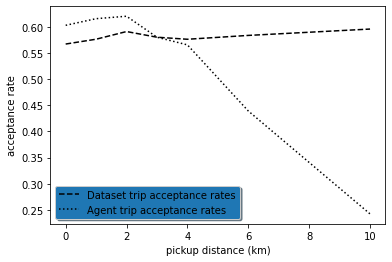

In [20]:
#draw graphs
"""
plt.plot([0]+pickup_distance_brackets, trip_acceptance_rates)
plt.xlabel('pickup distance (km)')
plt.ylabel('acceptance rate')
legned()
plt.show()
"""
# Make some fake data.
a = b = [0]+pickup_distance_brackets
c = pickup_acceptance_rates
d = pickup_acceptance_rates_agent

# Create plots with pre-defined labels.
fig, ax = plt.subplots()
ax.plot(a, c, 'k--', label='Dataset trip acceptance rates')
ax.plot(a, d, 'k:', label='Agent trip acceptance rates')
#ax.plot(a, c + d, 'k', label='Total message length')
plt.xlabel('pickup distance (km)')
plt.ylabel('acceptance rate')
legend = ax.legend(loc='best', shadow=True, fontsize='medium')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

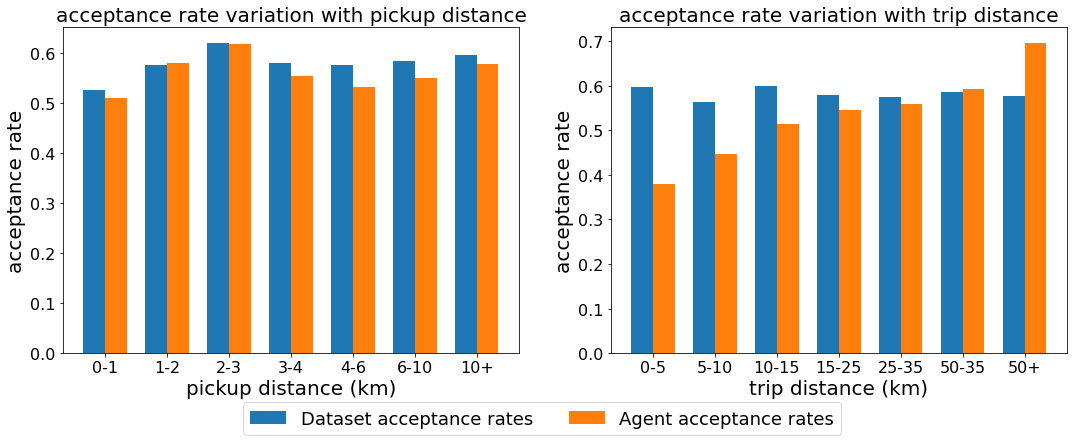

In [74]:
labels = ['0-1', '1-2', '2-3', '3-4', '4-6', '6-10', '10+']
men_means = [0.5270572916666666, 0.5762839879154078, 0.6209407665505226, 0.5801063022019742, 0.5761851015801355, 0.5835427135678392, 0.595703125]
women_means = [0.51046875, 0.5805740181268882, 0.6181881533101046, 0.5536142748671223, 0.5333182844243793, 0.5501256281407035, 0.578828125]
#men_means = pickup_acceptance_rates
#women_means = pickup_acceptance_rates_agent

labels1 = ['0-5', '5-10', '10-15', '15-25', '25-35', '50-35', '50+']
men_means1 = [0.5959821428571429, 0.5641864268192968, 0.6, 0.5790166812993854, 0.5739299610894941, 0.5859598853868195, 0.5761124121779859]
women_means1 = [0.37857142857142856, 0.4463614063777596, 0.51423487544483983, 0.546268656716418, 0.5578469520103762, 0.5914040114613181, 0.6959016393442623]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
rects1 = ax[0].bar(x - width/2, men_means, width, label='Dataset acceptance rates')
rects2 = ax[0].bar(x + width/2, women_means, width, label='Agent acceptance rates')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0].set_ylabel('acceptance rate', fontsize=20)
ax[0].set_xlabel('pickup distance (km)', fontsize=20)
ax[0].set_title('acceptance rate variation with pickup distance', fontsize=20)
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
#ax[0].legend(fontsize='medium')

rects1 = ax[1].bar(x - width/2, men_means1, width, label='Dataset acceptance rates')
rects2 = ax[1].bar(x + width/2, women_means1, width, label='Agent acceptance rates')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[1].set_ylabel('acceptance rate', fontsize=20)
ax[1].set_xlabel('trip distance (km)', fontsize=20)
ax[1].set_title('acceptance rate variation with trip distance', fontsize=20)
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels1, fontsize=16)
handles, labels = ax[1].get_legend_handles_labels()    
ax[1].legend(handles, labels, loc="center", bbox_to_anchor=(-0.15,-0.2),prop={'size': 18},ncol=2)
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


#autolabel(rects1)
#autolabel(rects2)

#fig.tight_layout()

plt.show()
fig.savefig('file', bbox_inches = "tight")

In [16]:
##########################################################################################
















Text(0.5, 0, 'Iterations')

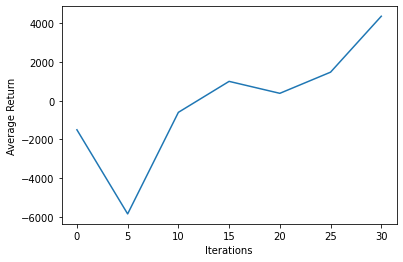

In [17]:
#visualize progress
iterations = range(0, num_iterations +1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
#plt.ylim(top=50000)

In [18]:
#run_simulation(eval_policy)
evaluatePolicy(eval_policy, eval_env)

0
0
0
0
0
0
0
[[ 8.2        39.5        13.         51.2430783  19.32878666 33.        ]]
70.63999999999999
[[ 4.3         6.5         6.         57.07621934 17.05308593 32.        ]]
-8.439999999999998
[[ 3.         22.2        13.         45.50722993  0.6880211  31.        ]]
50.640000000000015
driver reward  112.84
0
0
0
0
0
0
0
0
0
0
[[ 8.         35.2        16.          1.96451063 19.21204048 30.        ]]
58.24000000000001
0
[[12.5        35.8        18.         41.10034602 11.81089561 28.        ]]
29.560000000000002
[[ 6.6   27.9   19.    37.739 32.809 27.   ]]
44.400000000000006
0
0
0
[[ 1.8        24.5        20.         27.26182283 57.83749943 23.        ]]
66.16
0
0
0
0
[[ 2.9        30.          7.         28.44144467 27.45863014 18.        ]]
76.28000000000003
[[ 8.    26.9   11.    27.182 48.062 17.   ]]
31.680000000000007
0
[[ 6.6        29.5        12.         22.75285443 28.56852327 15.        ]]
49.52000000000001
[[ 4.3        19.3        12.         45.50746395 34.

[[ 5.7        21.5        17.         34.3967459  22.04908009  7.        ]]
30.04000000000002
[[ 6.6        22.6        19.         43.94979636  7.95079364  6.        ]]
27.439999999999998
driver reward  391.0400000000001
0
0
0
0
0
0
0
0
0
[[ 9.5        29.7        17.         42.22705811 51.45213318 31.        ]]
30.439999999999998
0
0
0
0
[[ 6.2        19.5        21.         34.66130283 40.17524641 26.        ]]
20.24000000000001
[[ 5.6        18.5        23.         41.32182016 51.63371454 25.        ]]
21.120000000000005
[[ 2.9        12.          0.         44.19246369 37.01732336 24.        ]]
18.680000000000007
[[ 7.9        17.9         8.         53.11921537 32.51309738 23.        ]]
3.5600000000000307
[[17.         26.2        12.         46.64092055 18.34635392 22.        ]]
-31.75999999999999
[[15.4        33.3        15.          6.28730047 25.44994481 21.        ]]
1.8400000000000318
0
[[17.3        30.5        15.         28.66769387 30.21042278 19.        ]]
-20.039999

[[ 3.8        40.3        14.         43.96910458  0.76922335 -1.        ]]
103.12000000000006
[[ 2.          7.3        16.         48.00585271  8.08324055 -1.        ]]
9.759999999999998
driver reward  2435.56
0
0
0
0
0
0
[[ 3.5        23.6        16.         31.53379354 24.97085848 34.        ]]
51.72
0
0
0
0
[[ 3.1        32.         18.         18.13226745 20.46507549 29.        ]]
81.32
0
0
0
0
0
0
0
0
0
[[ 6.6        29.7        19.         24.53027413 48.6341494  19.        ]]
50.160000000000025
0
[[ 4.9        26.8        20.         37.16093274 31.72507316 17.        ]]
52.44
[[ 8.         15.6        20.         43.3356227  36.30777483 16.        ]]
-4.480000000000018
0
0
[[13.1        40.3         9.         49.0002062  36.81574196 13.        ]]
39.879999999999995
[[11.9         7.7        14.         49.33032206 52.25475517 12.        ]]
-56.28
[[ 2.8    7.2   15.    53.82  44.863 11.   ]]
4.0
[[13.1         7.7        18.         48.54297897 48.93388183 10.        ]]
-64.

[[ 9.6        25.6        14.         25.31134782 26.53641193 -1.        ]]
16.639999999999986
0
[[11.1        12.3        14.         20.05334715 35.51396988 -1.        ]]
-36.119999999999976
[[ 5.6        20.2        14.         32.96211573 28.12348358 -1.        ]]
26.56000000000003
[[ 9.1        14.2        14.         32.16402155 46.44409902 -1.        ]]
-16.43999999999997
0
[[ 9.3        18.3        15.          3.08897228 28.1570356  -1.        ]]
-4.680000000000007
0
[[ 5.5        41.5        15.         47.47188715 42.14761042 -1.        ]]
95.40000000000003
[[ 6.2   45.4   15.     7.878 43.289 -1.   ]]
103.12
0
0
[[11.8        24.8        16.          1.75211253 27.19858773 -1.        ]]
-0.8799999999999955
0
[[12.3        16.2        16.         16.01638203 37.48175897 -1.        ]]
-31.799999999999983
[[10.1        18.6        16.         16.02745565 13.69229117 -1.        ]]
-9.160000000000025
[[ 9.2   13.8   16.    33.088  4.289 -1.   ]]
-18.400000000000006
driver reward

0
[[ 6.1        25.2        16.         23.92228914 50.95746099  8.        ]]
39.160000000000025
[[11.7        20.         16.         24.0732915  36.12081581  7.        ]]
-15.560000000000002
0
0
[[ 7.8        13.2        17.         21.67499399 31.88015445  4.        ]]
-10.799999999999983
[[17.    33.6   17.     6.412 43.181  3.   ]]
-8.079999999999984
0
[[10.4        45.6        17.         32.64633529 19.2459085   1.        ]]
1575.2
[[16.4        10.4        17.         28.41608275 23.75577388  0.        ]]
-78.23999999999998
[[ 6.6   23.2   17.     4.228 38.111 -1.   ]]
29.360000000000014
0
0
[[19.9   23.5   18.     5.17  34.497 -1.   ]]
-60.120000000000005
[[24.1   25.1   18.    16.572 31.457 -1.   ]]
-83.56
[[14.6        27.4        18.         37.30622022 50.02339643 -1.        ]]
-11.599999999999966
[[ 7.7         7.2        19.         32.88302925 50.32385391 -1.        ]]
-29.319999999999993
[[29.6        27.9        19.         38.26119619 36.66139208 -1.        ]]
-112.0

[[ 4.7   11.1   18.    50.226 34.902 -1.   ]]
3.5600000000000023
[[ 6.6         3.4        19.         50.47388283 30.33884907 -1.        ]]
-34.0
driver reward  2238.2799999999993
[[12.2   37.4   12.    12.872 21.952 40.   ]]
36.72000000000003
0
0
0
[[15.1        43.5        17.         58.12308442  6.90995102 36.        ]]
36.51999999999998
0
[[ 2.1        32.7         4.         27.915741   27.34701261 34.        ]]
90.35999999999999
0
0
0
[[ 1.8        30.1        14.         30.89624768  4.48163468 30.        ]]
84.07999999999998
0
0
0
[[ 2.7        24.9        12.         27.41162801 39.52144174 26.        ]]
61.32000000000002
0
[[24.4        57.         12.         22.57359205  2.8753626  24.        ]]
16.480000000000018
0
0
0
0
0
0
0
0
[[ 1.3        13.5        18.         25.44312144 40.33698701 15.        ]]
34.36
0
0
[[ 5.3        19.8        19.         25.39491704 40.77653359 12.        ]]
27.319999999999993
0
0
0
0
[[ 5.2        44.1        19.         20.9463667  17.0806

0
0
0
0
0
0
0
0
0
0
0
0
[[ 2.4        23.9        16.         12.95408403  8.73235814 23.        ]]
60.160000000000025
[[ 7.6        24.1        16.         39.93998193  8.69786214 22.        ]]
25.439999999999998
[[ 3.9   39.6    0.    54.19  45.493 21.   ]]
100.19999999999999
[[ 6.2        21.4         9.         40.19687593 35.62546671 20.        ]]
26.32000000000002
[[ 4.2        7.3       12.        31.7390306 30.4559885 19.       ]]
-5.200000000000003
[[ 5.9        19.5        12.         45.50360585 31.86193071 18.        ]]
22.28
0
[[ 6.3   27.9    7.     9.505 26.591 16.   ]]
46.440000000000026
[[ 2.5        18.9         7.         25.75538577 39.41094174 15.        ]]
43.48000000000002
[[ 6.4        23.1         9.         44.22629945 40.81804425 14.        ]]
30.400000000000006
[[12.7   32.6   12.     1.619 35.228 13.   ]]
17.960000000000036
0
[[13.3        12.5        12.         26.41073518 23.11619052 11.        ]]
-50.44
0
0
[[ 9.2        36.4        14.          0.29173

0
[[14.9        29.5        18.         10.82711297 21.24371819 -1.        ]]
-6.919999999999959
[[ 8.4        17.8        18.         11.92068284 31.66413289 -1.        ]]
-0.160000000000025
0
[[10.3        16.2        19.         13.30283957 26.46458734 -1.        ]]
-18.19999999999999
[[ 4.         11.8        19.         18.75679716 20.03796699 -1.        ]]
10.560000000000002
[[ 7.4        12.3        19.         31.18390158  6.10143465 -1.        ]]
-10.960000000000008
[[17.3        23.9        21.         41.83559759 30.13647855 -1.        ]]
-41.160000000000025
[[ 3.4        22.1        23.         30.76401353 48.06491883 -1.        ]]
47.599999999999994
0
[[11.6        23.1         5.         12.54631805 13.28034491 -1.        ]]
-4.960000000000008
[[13.6        22.3         8.         21.38865884 33.60480374 -1.        ]]
-21.119999999999976
0
0
0
0
0
0
0
0
0
[[ 8.2        38.9        13.         32.36776636 12.09121277 -1.        ]]
68.72000000000003
[[ 1.7    1.2   19.    3

0
0
0
0
[[10.         17.         20.         22.33067945 52.61659853 -1.        ]]
-13.599999999999994
0
[[ 4.         15.         20.         21.42429527 46.37969085 -1.        ]]
20.80000000000001
0
0
[[ 5.7        10.6        23.         12.15675868 31.73889458 -1.        ]]
-4.840000000000003
[[ 7.1        30.         23.         37.79503218 22.05075648 -1.        ]]
47.72
[[11.         13.8         8.         31.48913576 39.38486425 -1.        ]]
-30.639999999999986
0
[[12.1        35.1        10.         46.6141507  47.52233042 -1.        ]]
30.039999999999964
[[10.7        30.         12.         28.06228826 53.11727487 -1.        ]]
23.24000000000001
[[11.1   27.4   12.     9.875 47.871 -1.   ]]
12.199999999999989
[[ 6.9        10.4        13.         21.47244828 36.50838642 -1.        ]]
-13.64
[[ 3.4   17.1   13.     3.409 29.619 -1.   ]]
31.599999999999994
[[ 8.7        15.2        13.         22.04361577 35.17336825 -1.        ]]
-10.519999999999982
0
[[ 1.2   20.    13.  

<ipython-input-9-ff47d4624acb>:33: RuntimeWarning: invalid value encountered in double_scalars
  hrly_acceptance_rates.append(hrly_accepted_trips[j]/hrly_trip_counts[j])


In [52]:
#evaluate a trained policy with respect to a pre-generated static environment
def evaluateSavedPolicy(policy, policy_state, eval_env):
    episode_reward = 0
    for state_list in eval_env:
        states = []
        driver_reward = 0
        
        for i in range(len(state_list)):
            state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
            action = policy.action(state_tf, policy_state)

            #action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
            if (action[0].numpy() == 1):
                reward = state_list[i]["reward"]
            else:
                reward = 0
            print (reward)
            driver_reward += reward
        episode_reward += driver_reward
        print("driver reward ", driver_reward)
    print("total reward ", episode_reward)


In [19]:
#load saved policy
saved_policy = tf.compat.v2.saved_model.load('pol/policy_10')
policy_state = saved_policy.get_initial_state(batch_size=3)
"""time_step = ...
while True:
  policy_step = saved_policy.action(time_step, policy_state)
  policy_state = policy_step.state
  time_step = f(policy_step.action)
"""
observations = [8, 10, 0, 35]
#observation_ts = ts.transition(np.array(observations, dtype=np.float32), reward=0.0, discount=1.0)
observation_ts = ts.TimeStep(tf.constant([1]), tf.constant([0.0]), tf.constant([1.0]),
                                tf.convert_to_tensor(np.array([observations], dtype=np.float32), dtype=tf.float32))
action = saved_policy.action(observation_ts, policy_state)
print(action)

OSError: SavedModel file does not exist at: pol/policy_10/{saved_model.pbtxt|saved_model.pb}

In [ ]:
avg_return = compute_avg_return(saved_policy, num_eval_episodes)

In [ ]:
#evaluateSavedPolicy(saved_policy, policy_state, eval_env)
evaluatePolicy(eval_policy, eval_env)

In [ ]:
"""


reward results - 
random policy - around 9.5k
learned policy - 14k
always accept policy - 19.4k
"""

##############################################################################################



In [ ]:
# startup simulation

def simpy_episode(rewards, steps, time_step, tf_env, policy):

    TIME_MULTIPLIER = 50
    DRIVER_COUNT = 1
    TRIP_COUNT = 8000
    RUN_TIME = 10000
    INTERVAL = 20
    # GRID_WIDTH = 3809
    # GRID_HEIGHT = 2622
    GRID_WIDTH = 60
    GRID_HEIGHT = 40
    HEX_AREA = 2.6

    Env = simpy.Environment()
    map_grid = Grid(env=Env, width=GRID_WIDTH, height=GRID_HEIGHT, interval=INTERVAL, num_drivers=DRIVER_COUNT,
                    hex_area=HEX_AREA)

    taxi_spots = map_grid.taxi_spots
    driver_list = create_drivers(Env, DRIVER_COUNT, map_grid)
    driver_pools = map_grid.driver_pools

    run_simulation(TRIP_COUNT, RUN_TIME, DRIVER_COUNT, TIME_MULTIPLIER, map_grid, taxi_spots, driver_list, driver_pools, Env, rewards, steps, time_step, tf_env, policy)
    t_count = 0
    for dr in driver_list:
        d_t_count = dr.total_trip_count
        t_count += d_t_count
        print(f"{dr.id} completed {d_t_count}")

    print(f"Total trip count: {t_count}")

In [ ]:
var = tf.random.uniform([1], 0, 2, dtype=tf.int32)
var[0] = 2
print (var)

In [ ]:
#simple episode run - atttempt 1

time_step = tf_env.reset()
rewards = []
steps = []
num_episodes = 5

for _ in range(num_episodes):
    simpy_episode(rewards, step, time_step, tf_env, policy)

    action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
    time_step = tf_env.step(action)
    episode_steps += 1
    episode_reward += time_step.reward.numpy()
  rewards.append(episode_reward)
  steps.append(episode_steps)
  time_step = tf_env.reset()

num_steps = np.sum(steps)
avg_length = np.mean(steps)
avg_reward = np.mean(rewards)

In [ ]:
#simple episode run - atttempt 2

#time_step = tf_env.reset()
rewards = []
steps = []
num_episodes = 5

for _ in range(num_episodes):
    time_step = tf_env.reset()
    
    
    
    
    
    
    simpy_episode(rewards, step, time_step, tf_env, policy)

    action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
    time_step = tf_env.step(action)
    episode_steps += 1
    episode_reward += time_step.reward.numpy()
  rewards.append(episode_reward)
  steps.append(episode_steps)
  time_step = tf_env.reset()

num_steps = np.sum(steps)
avg_length = np.mean(steps)
avg_reward = np.mean(rewards)

In [3]:
#simple episode run template
"""
time_step = tf_env.reset()
rewards = []
steps = []
num_episodes = 5

for _ in range(num_episodes):
  episode_reward = 0
  episode_steps = 0
  while not time_step.is_last():
    action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
    time_step = tf_env.step(action)
    episode_steps += 1
    episode_reward += time_step.reward.numpy()
  rewards.append(episode_reward)
  steps.append(episode_steps)
  time_step = tf_env.reset()

num_steps = np.sum(steps)
avg_length = np.mean(steps)
avg_reward = np.mean(rewards)

print('num_episodes:', num_episodes, 'num_steps:', num_steps)
print('avg_length', avg_length, 'avg_reward:', avg_reward)
"""

"\ntime_step = tf_env.reset()\nrewards = []\nsteps = []\nnum_episodes = 5\n\nfor _ in range(num_episodes):\n  episode_reward = 0\n  episode_steps = 0\n  while not time_step.is_last():\n    action = tf.random.uniform([1], 0, 2, dtype=tf.int32)\n    time_step = tf_env.step(action)\n    episode_steps += 1\n    episode_reward += time_step.reward.numpy()\n  rewards.append(episode_reward)\n  steps.append(episode_steps)\n  time_step = tf_env.reset()\n\nnum_steps = np.sum(steps)\navg_length = np.mean(steps)\navg_reward = np.mean(rewards)\n\nprint('num_episodes:', num_episodes, 'num_steps:', num_steps)\nprint('avg_length', avg_length, 'avg_reward:', avg_reward)\n"

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
(500, 267)
5.3919373
5.5419006
nan
nan
conv 1.6891718407829268 1.6434600975557612


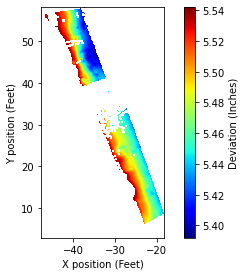

(array([], dtype=int64), array([], dtype=int64))


In [6]:
from matplotlib.figure import Figure

#img = np.load("1600332703880_npimg.npy", allow_pickle=True)
img = np.load("1600371385971_npimg.npy", encoding = 'bytes')
img = img[:, 1:]
fig = plt.figure()
print(img)
print(img.shape)

print(np.nanmin(img[img != -np.inf]))
print(np.nanmax(img[img != np.inf]))

zmax = np.nanmin(img[img != -np.inf])
zmin = np.nanmax(img[img != np.inf])
print(img.max())
print(img.min())
"""
maxz= 298.6142120361328/2
minz= 298.4643096923828/2
maxx= 2.2676000595092773
minx= -2.5011000633239746
maxy= 3.3237826631069183
miny= 0.47209998965263367
"""
maxx= -18.123884002685546
maxy= 58.166160583496094
maxz= 5.541902542114258
minx= -47.775150299072266
miny= 2.8466339111328125
minz= 5.391929626464844

print("conv", maxz/3.28084, minz/3.28084)
ax = fig.add_axes([.57,.05,.9,.8])
ax.set_xlabel("X position (Feet)")
ax.set_ylabel("Y position (Feet)")

img_plotted = ax.imshow(
        img,
        vmin=minz,
        vmax=maxz,
        extent=(minx, maxx, miny, maxy),
        cmap = 'jet'
    )

fig.colorbar(img_plotted).set_label("Deviation (Inches)")

plt.show()
nanRem = img[~np.isnan(img)]
np.histogram(nanRem[nanRem != np.inf])

print(np.where(img==147.25175))

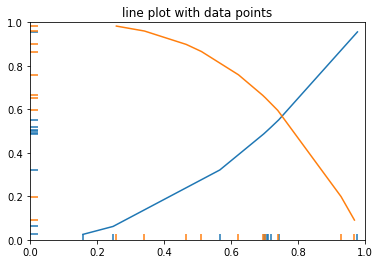

In [7]:
import matplotlib.pyplot as plt
from matplotlib.collections import EventCollection
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)

# create random data
xdata = np.random.random([2, 10])

# split the data into two parts
xdata1 = xdata[0, :]
xdata2 = xdata[1, :]

# sort the data so it makes clean curves
xdata1.sort()
xdata2.sort()

# create some y data points
ydata1 = xdata1 ** 2
ydata2 = 1 - xdata2 ** 3

# plot the data
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(xdata1, ydata1, color='tab:blue')
ax.plot(xdata2, ydata2, color='tab:orange')

# create the events marking the x data points
xevents1 = EventCollection(xdata1, color='tab:blue', linelength=0.05)
xevents2 = EventCollection(xdata2, color='tab:orange', linelength=0.05)

# create the events marking the y data points
yevents1 = EventCollection(ydata1, color='tab:blue', linelength=0.05,
                           orientation='vertical')
yevents2 = EventCollection(ydata2, color='tab:orange', linelength=0.05,
                           orientation='vertical')

# add the events to the axis
ax.add_collection(xevents1)
ax.add_collection(xevents2)
ax.add_collection(yevents1)
ax.add_collection(yevents2)

# set the limits
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

ax.set_title('line plot with data points')

# display the plot
plt.show()